In [14]:
# ============================================================
# SECTION 1: IMPORT LIBRARIES
# ============================================================
# What we're doing: Loading libraries for data manipulation and preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [15]:
# ============================================================
# SECTION 2: LOAD RAW DATA
# ============================================================
# What we're doing: Reading the Parkinson's dataset
# Same data from EDA, but now we'll transform it

df = pd.read_csv('../../datasets/parkinsons_updrs.data')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset loaded successfully!
Shape: (5875, 22)
Columns: ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


In [16]:
# ============================================================
# SECTION 3: DEFINE FEATURE GROUPS
# ============================================================
# What we're doing: Organizing features into logical groups
# Why: Makes it easier to engineer features and understand what we're using

# Voice feature groups
jitter_features = ['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP']
shimmer_features = ['Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA']
noise_features = ['NHR', 'HNR']
complexity_features = ['RPDE', 'DFA', 'PPE']

# All voice features (16 total)
all_voice_features = jitter_features + shimmer_features + noise_features + complexity_features

# Demographic/context features
demographic_features = ['age', 'sex', 'test_time']

# Target variables (what we want to predict)
target_motor = 'motor_UPDRS'
target_total = 'total_UPDRS'

print(f"\n📊 FEATURE SUMMARY:")
print(f"Voice features: {len(all_voice_features)}")
print(f"Demographic features: {len(demographic_features)}")
print(f"Total predictors: {len(all_voice_features) + len(demographic_features)}")
print(f"Target variables: 2 ({target_motor}, {target_total})")


📊 FEATURE SUMMARY:
Voice features: 16
Demographic features: 3
Total predictors: 19
Target variables: 2 (motor_UPDRS, total_UPDRS)


In [17]:
# ============================================================
# SECTION 4: FEATURE ENGINEERING - CREATE NEW FEATURES
# ============================================================
# What we're doing: Creating new features from existing ones
# Why: Capture complex relationships that individual features might miss
# 
# New features we're creating:
# 1. Aggregated Jitter: Sum of all 5 jitter measures (total pitch instability)
# 2. Aggregated Shimmer: Sum of all 6 shimmer measures (total amplitude instability)
# 3. Voice Quality Index: HNR / (Jitter + Shimmer) → Higher = better voice
# 4. Jitter-Shimmer Interaction: Jitter × Shimmer → Combined instability
# 5. Test Months: Convert days to months for interpretability
# 6. Age × Test Time: Interaction (older patients + longer time → worse?)

print("Creating engineered features...\n")

# 1. Total Jitter (sum of all jitter measures)
df['total_jitter'] = df[jitter_features].sum(axis=1)
print("✅ Created 'total_jitter': Sum of all 5 jitter measures")

# 2. Total Shimmer (sum of all shimmer measures)
df['total_shimmer'] = df[shimmer_features].sum(axis=1)
print("✅ Created 'total_shimmer': Sum of all 6 shimmer measures")

# 3. Voice Quality Index (higher = better voice)
# Avoid division by zero by adding small constant
df['voice_quality'] = df['HNR'] / (df['Jitter(%)'] + df['Shimmer'] + 0.001)
print("✅ Created 'voice_quality': HNR / (Jitter + Shimmer) - overall voice health metric")

# 4. Jitter-Shimmer Interaction (combined instability)
df['jitter_shimmer_interaction'] = df['Jitter(%)'] * df['Shimmer']
print("✅ Created 'jitter_shimmer_interaction': Jitter × Shimmer - synergistic effect")

# 5. Test time in months (more interpretable than days)
df['test_months'] = df['test_time'] / 30
print("✅ Created 'test_months': Days since recruitment / 30")

# 6. Age-Time Interaction (older + longer time → worse disease?)
df['age_time_interaction'] = df['age'] * df['test_months']
print("✅ Created 'age_time_interaction': Age × Test Months")

# 7. Noise Ratio (NHR/HNR ratio - alternative noise metric)
df['noise_ratio'] = df['NHR'] / (df['HNR'] + 0.001)
print("✅ Created 'noise_ratio': NHR / HNR - alternative noise measure")

# List of all engineered features
engineered_features = ['total_jitter', 'total_shimmer', 'voice_quality', 
                       'jitter_shimmer_interaction', 'test_months', 
                       'age_time_interaction', 'noise_ratio']

print(f"\n✅ Total engineered features created: {len(engineered_features)}")
print(f"New total features: {len(all_voice_features) + len(demographic_features) + len(engineered_features)}")

Creating engineered features...

✅ Created 'total_jitter': Sum of all 5 jitter measures
✅ Created 'total_shimmer': Sum of all 6 shimmer measures
✅ Created 'voice_quality': HNR / (Jitter + Shimmer) - overall voice health metric
✅ Created 'jitter_shimmer_interaction': Jitter × Shimmer - synergistic effect
✅ Created 'test_months': Days since recruitment / 30
✅ Created 'age_time_interaction': Age × Test Months
✅ Created 'noise_ratio': NHR / HNR - alternative noise measure

✅ Total engineered features created: 7
New total features: 26


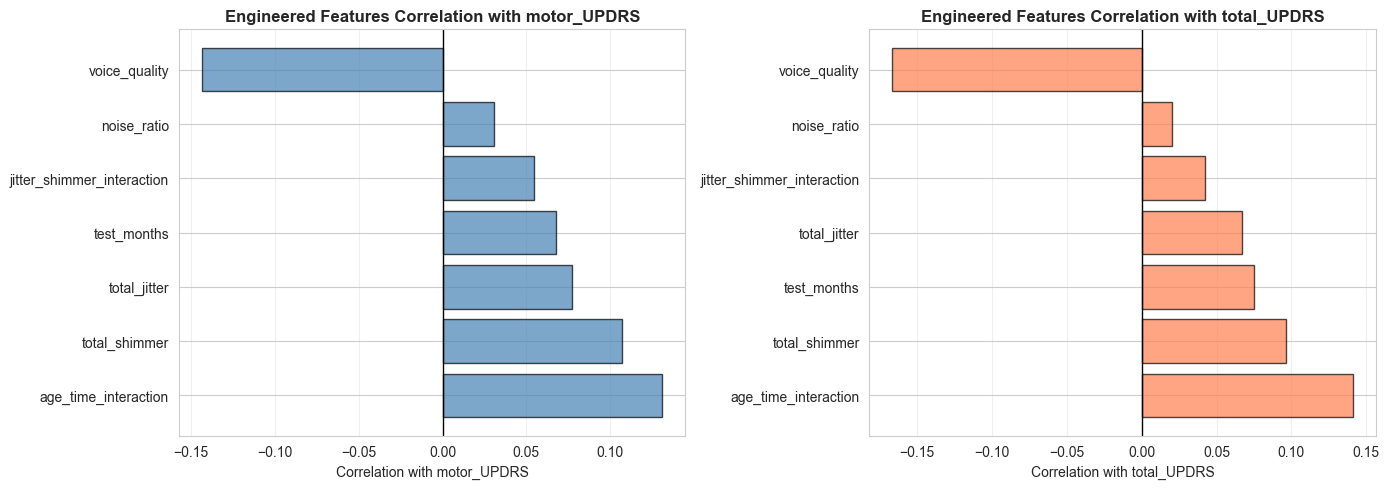


🔍 ENGINEERED FEATURES CORRELATIONS:

With motor_UPDRS:
  age_time_interaction           → r = +0.131
  total_shimmer                  → r = +0.107
  total_jitter                   → r = +0.077
  test_months                    → r = +0.068
  jitter_shimmer_interaction     → r = +0.054
  noise_ratio                    → r = +0.031
  voice_quality                  → r = -0.144

With total_UPDRS:
  age_time_interaction           → r = +0.141
  total_shimmer                  → r = +0.097
  test_months                    → r = +0.075
  total_jitter                   → r = +0.067
  jitter_shimmer_interaction     → r = +0.042
  noise_ratio                    → r = +0.020
  voice_quality                  → r = -0.166

💡 Interpretation:
- |r| > 0.1: Feature is useful (keep it!)
- |r| < 0.1: Feature adds little value (will be removed)
  ❌ Removing 'total_jitter': |r_motor|=0.077, |r_total|=0.067 (too weak)
  ✅ Keeping 'total_shimmer': |r_motor|=0.107, |r_total|=0.097
  ✅ Keeping 'voice_quality':

In [18]:
# ============================================================
# SECTION 5: CHECK ENGINEERED FEATURES CORRELATION WITH TARGETS
# ============================================================
# What we're doing: Verifying that our new features are actually useful
# How: Check correlation with motor_UPDRS and total_UPDRS
# Why: Only keep features that add predictive value

# Calculate correlations
corr_motor = df[engineered_features + [target_motor]].corr()[target_motor].drop(target_motor).sort_values(ascending=False)
corr_total = df[engineered_features + [target_total]].corr()[target_total].drop(target_total).sort_values(ascending=False)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(corr_motor.index, corr_motor.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Correlation with motor_UPDRS')
axes[0].set_title('Engineered Features Correlation with motor_UPDRS', fontweight='bold')
axes[0].axvline(0, color='black', linewidth=1)
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(corr_total.index, corr_total.values, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Correlation with total_UPDRS')
axes[1].set_title('Engineered Features Correlation with total_UPDRS', fontweight='bold')
axes[1].axvline(0, color='black', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 ENGINEERED FEATURES CORRELATIONS:")
print("="*60)
print(f"\nWith motor_UPDRS:")
for feat, corr in corr_motor.items():
    print(f"  {feat:30s} → r = {corr:+.3f}")
    
print(f"\nWith total_UPDRS:")
for feat, corr in corr_total.items():
    print(f"  {feat:30s} → r = {corr:+.3f}")

print("\n💡 Interpretation:")
print("- |r| > 0.1: Feature is useful (keep it!)")
print("- |r| < 0.1: Feature adds little value (will be removed)")

# Filter to keep only features with |r| > 0.1 for EITHER motor_UPDRS or total_UPDRS
features_to_keep = []
for feat in engineered_features:
    r_motor = abs(corr_motor[feat])
    r_total = abs(corr_total[feat])
    if r_motor > 0.1 or r_total > 0.1:
        features_to_keep.append(feat)
        print(f"  ✅ Keeping '{feat}': |r_motor|={r_motor:.3f}, |r_total|={r_total:.3f}")
    else:
        print(f"  ❌ Removing '{feat}': |r_motor|={r_motor:.3f}, |r_total|={r_total:.3f} (too weak)")

# Update engineered_features to only include useful ones
engineered_features = features_to_keep

print(f"\n📊 FINAL ENGINEERED FEATURES: {len(engineered_features)} kept")
print(f"   {engineered_features}")

In [19]:
# ============================================================
# SECTION 6: PREPARE FEATURE MATRIX AND TARGET VECTORS
# ============================================================
# What we're doing: Separating predictors (X) from targets (y)
# 
# X = All features we'll use to predict (voice + demographics + engineered)
# y_motor = motor_UPDRS (what we predict in regression task 1)
# y_total = total_UPDRS (what we predict in regression task 2)

# Combine all predictor features
all_predictor_features = all_voice_features + demographic_features + engineered_features

# Create feature matrix X (all predictors)
X = df[all_predictor_features].copy()

# Create target vectors
y_motor = df[target_motor].copy()
y_total = df[target_total].copy()

print("\n📊 DATA PREPARATION SUMMARY:")
print("="*60)
print(f"Feature matrix X: Shape = {X.shape}")
print(f"  - {X.shape[0]} recordings (samples)")
print(f"  - {X.shape[1]} features (predictors)")
print(f"\nBreakdown:")
print(f"  - Original voice features: {len(all_voice_features)}")
print(f"  - Demographic features: {len(demographic_features)}")
print(f"  - Engineered features: {len(engineered_features)}")
print(f"  - Total: {len(all_predictor_features)}")
print(f"\nTarget vector y_motor (motor_UPDRS): Shape = {y_motor.shape}")
print(f"Target vector y_total (total_UPDRS): Shape = {y_total.shape}")

# Preview
print("\n👀 First 5 rows of X:")
X.head()


📊 DATA PREPARATION SUMMARY:
Feature matrix X: Shape = (5875, 22)
  - 5875 recordings (samples)
  - 22 features (predictors)

Breakdown:
  - Original voice features: 16
  - Demographic features: 3
  - Engineered features: 3
  - Total: 22

Target vector y_motor (motor_UPDRS): Shape = (5875,)
Target vector y_total (total_UPDRS): Shape = (5875,)

👀 First 5 rows of X:


,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,...,HNR,RPDE,DFA,PPE,age,sex,test_time,total_shimmer,voice_quality,age_time_interaction
0,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,...,21.640,0.41888,0.54842,0.16006,72,0,5.6431,0.34288,650.435828,13.54344
1,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,...,27.183,0.43493,0.56477,0.10810,72,0,12.6660,0.26661,1121.410891,30.39840
2,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,...,23.047,0.46222,0.54405,0.21014,72,0,19.6810,0.25013,1021.586879,47.23440
3,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,...,24.445,0.48730,0.57794,0.33277,72,0,25.6470,0.42660,832.311883,61.55280
4,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,...,26.126,0.47188,0.56122,0.19361,72,0,33.6420,0.24766,1221.983162,80.74080


In [20]:
# ============================================================
# SECTION 7: CHECK FOR MISSING VALUES (FINAL CHECK)
# ============================================================
# What we're doing: Ensuring no NaN or infinite values after feature engineering
# Why: Models will crash if we have NaN/inf values

print("Checking for missing or invalid values...\n")

# Check for NaN
nan_count = X.isnull().sum().sum()
if nan_count > 0:
    print(f"⚠️ Found {nan_count} NaN values!")
    print(X.isnull().sum()[X.isnull().sum() > 0])
else:
    print("✅ No NaN values found")

# Check for infinite values
inf_count = np.isinf(X).sum().sum()
if inf_count > 0:
    print(f"\n⚠️ Found {inf_count} infinite values!")
    print(np.isinf(X).sum()[np.isinf(X).sum() > 0])
else:
    print("✅ No infinite values found")

# Replace any NaN/inf with median (safety measure)
if nan_count > 0 or inf_count > 0:
    print("\n🔧 Fixing invalid values by replacing with column median...")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("✅ Fixed!")

print("\n✅ Data is clean and ready for scaling!")

Checking for missing or invalid values...

✅ No NaN values found
✅ No infinite values found

✅ Data is clean and ready for scaling!
✅ No infinite values found

✅ Data is clean and ready for scaling!


In [21]:
# ============================================================
# SECTION 8: FEATURE SCALING (STANDARDIZATION)
# ============================================================
# What we're doing: Scaling all features to have mean=0 and std=1
# Why: Features have vastly different scales
#   - Jitter(%): ~0.005 (very small)
#   - HNR: ~21 (large)
#   - age: ~65 (large)
# 
# Without scaling:
#   - Models focus on large-scale features (HNR, age)
#   - Ignore small-scale features (Jitter)
#   - Neural networks train slowly
#   - Distance-based algorithms fail
# 
# With StandardScaler:
#   - All features treated equally
#   - Formula: X_scaled = (X - mean) / std
#   - Result: Mean=0, Std=1 for all features

print("\n📏 FEATURE SCALES BEFORE SCALING:")
print("="*60)
print(f"{'Feature':<30} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-"*60)
for col in X.columns[:5]:  # Show first 5 as examples
    print(f"{col:<30} {X[col].mean():>10.4f} {X[col].std():>10.4f} {X[col].min():>10.4f} {X[col].max():>10.4f}")
print("...")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on X and transform
# IMPORTANT: Fit on training data only to avoid data leakage (we'll do this after split)
# For now, we'll demonstrate scaling on full dataset for visualization
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame to keep column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("\n📏 FEATURE SCALES AFTER SCALING:")
print("="*60)
print(f"{'Feature':<30} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-"*60)
for col in X_scaled_df.columns[:5]:  # Show first 5 as examples
    print(f"{col:<30} {X_scaled_df[col].mean():>10.4f} {X_scaled_df[col].std():>10.4f} {X_scaled_df[col].min():>10.4f} {X_scaled_df[col].max():>10.4f}")
print("...")

print("\n✅ All features now have mean ≈ 0 and std ≈ 1!")
print("💡 This ensures equal treatment by ML models.")


📏 FEATURE SCALES BEFORE SCALING:
Feature                              Mean        Std        Min        Max
------------------------------------------------------------
Jitter(%)                          0.0062     0.0056     0.0008     0.1000
Jitter(Abs)                        0.0000     0.0000     0.0000     0.0004
Jitter:RAP                         0.0030     0.0031     0.0003     0.0575
Jitter:PPQ5                        0.0033     0.0037     0.0004     0.0696
Jitter:DDP                         0.0090     0.0094     0.0010     0.1726
...

📏 FEATURE SCALES AFTER SCALING:
Feature                              Mean        Std        Min        Max
------------------------------------------------------------
Jitter(%)                          0.0000     1.0001    -0.9467    16.6857
Jitter(Abs)                        0.0000     1.0001    -1.1611    11.1606
Jitter:RAP                         0.0000     1.0001    -0.8507    17.4650
Jitter:PPQ5                       -0.0000     1.0001    -

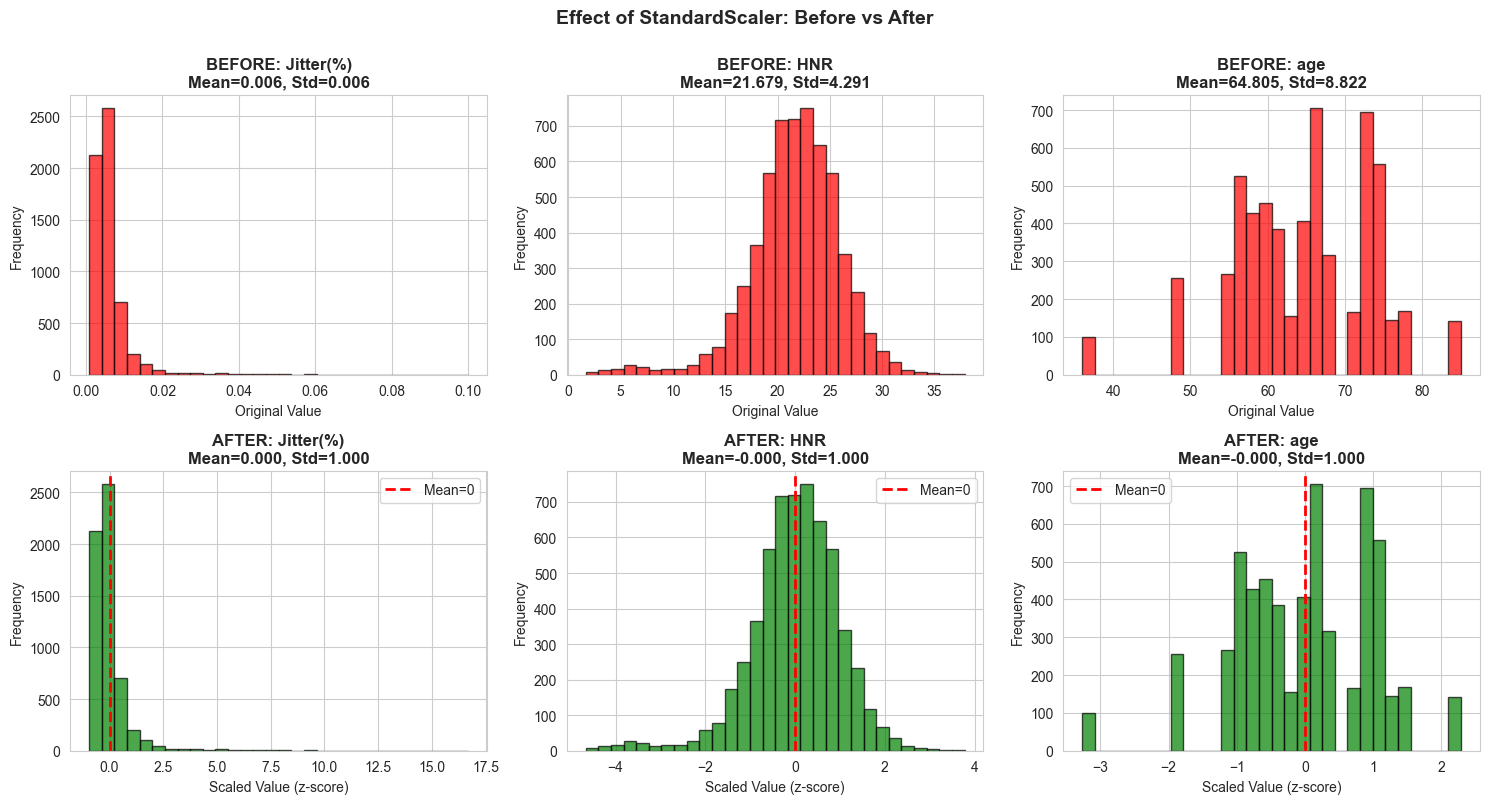


💡 Observations:
- Top row: Original features have different scales
- Bottom row: Scaled features all centered at 0 with std=1
- Shape of distribution UNCHANGED (only scale changes)


In [22]:
# ============================================================
# SECTION 9: VISUALIZE SCALING EFFECT
# ============================================================
# What we're doing: Comparing distributions before and after scaling
# Why: Visual confirmation that scaling worked correctly

# Select 3 features with very different scales
example_features = ['Jitter(%)', 'HNR', 'age']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, feature in enumerate(example_features):
    # Before scaling (top row)
    axes[0, i].hist(X[feature], bins=30, color='red', alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'BEFORE: {feature}\nMean={X[feature].mean():.3f}, Std={X[feature].std():.3f}', fontweight='bold')
    axes[0, i].set_xlabel('Original Value')
    axes[0, i].set_ylabel('Frequency')
    
    # After scaling (bottom row)
    axes[1, i].hist(X_scaled_df[feature], bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[1, i].set_title(f'AFTER: {feature}\nMean={X_scaled_df[feature].mean():.3f}, Std={X_scaled_df[feature].std():.3f}', fontweight='bold')
    axes[1, i].set_xlabel('Scaled Value (z-score)')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean=0')
    axes[1, i].legend()

plt.suptitle('Effect of StandardScaler: Before vs After', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("- Top row: Original features have different scales")
print("- Bottom row: Scaled features all centered at 0 with std=1")
print("- Shape of distribution UNCHANGED (only scale changes)")

In [23]:
# ============================================================
# SECTION 10: TRAIN/TEST SPLIT (80/20)
# ============================================================
# What we're doing: Splitting data into training set (80%) and test set (20%)
# 
# Why we split:
# - Training set: Used to train models (learn patterns)
# - Test set: Used to evaluate models (never seen during training)
# - Prevents overfitting: Model can't memorize test data
# 
# IMPORTANT DECISION:
# - Random split: Same patient may appear in both train and test
# - Patient-based split: Some patients in train, others in test
# - We'll use RANDOM split (simpler, more data per patient)
# - Trade-off: Slight optimistic bias (same patient in both sets)
# 
# Split strategy:
# - 80% train (4,700 recordings)
# - 20% test (1,175 recordings)
# - random_state=42 (reproducible results)
# - stratify: Not needed (continuous targets, not classification)

print("Splitting data into train/test sets...\n")

# Split for motor_UPDRS prediction
X_train_motor, X_test_motor, y_train_motor, y_test_motor = train_test_split(
    X_scaled_df, y_motor, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Split for total_UPDRS prediction (same X split, different y)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    X_scaled_df, y_total, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print("✅ Data split complete!\n")
print("="*60)
print("📊 TRAIN/TEST SPLIT SUMMARY:")
print("="*60)
print(f"\nOriginal dataset: {len(X_scaled_df)} recordings")
print(f"\nFor motor_UPDRS prediction:")
print(f"  Training set:   X_train_motor = {X_train_motor.shape}, y_train_motor = {y_train_motor.shape}")
print(f"  Test set:       X_test_motor  = {X_test_motor.shape}, y_test_motor  = {y_test_motor.shape}")
print(f"  Split ratio:    {len(X_train_motor)/len(X_scaled_df)*100:.1f}% train, {len(X_test_motor)/len(X_scaled_df)*100:.1f}% test")
print(f"\nFor total_UPDRS prediction:")
print(f"  Training set:   X_train_total = {X_train_total.shape}, y_train_total = {y_train_total.shape}")
print(f"  Test set:       X_test_total  = {X_test_total.shape}, y_test_total  = {y_test_total.shape}")
print(f"  Split ratio:    {len(X_train_total)/len(X_scaled_df)*100:.1f}% train, {len(X_test_total)/len(X_scaled_df)*100:.1f}% test")

print("\n💡 Note: X_train_motor and X_train_total are identical (same features)")
print("   Only the target variables (y) differ!")

Splitting data into train/test sets...

✅ Data split complete!

📊 TRAIN/TEST SPLIT SUMMARY:

Original dataset: 5875 recordings

For motor_UPDRS prediction:
  Training set:   X_train_motor = (4700, 22), y_train_motor = (4700,)
  Test set:       X_test_motor  = (1175, 22), y_test_motor  = (1175,)
  Split ratio:    80.0% train, 20.0% test

For total_UPDRS prediction:
  Training set:   X_train_total = (4700, 22), y_train_total = (4700,)
  Test set:       X_test_total  = (1175, 22), y_test_total  = (1175,)
  Split ratio:    80.0% train, 20.0% test

💡 Note: X_train_motor and X_train_total are identical (same features)
   Only the target variables (y) differ!


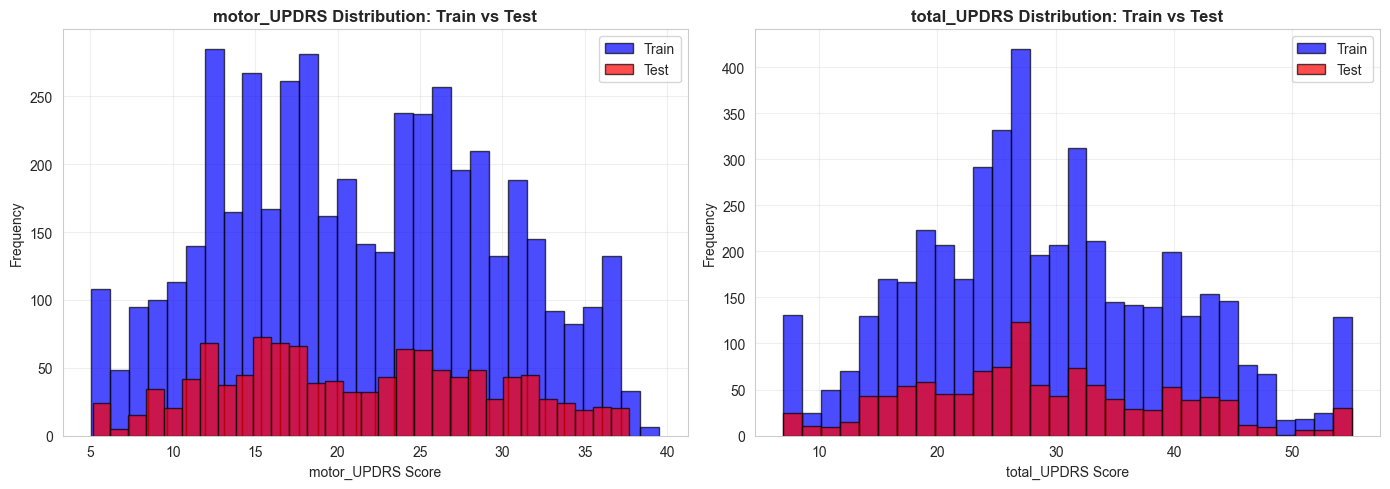


📊 DISTRIBUTION STATISTICS:

motor_UPDRS:
  Train: Mean = 21.33, Std = 8.16
  Test:  Mean = 21.15, Std = 7.99
  Difference: 0.18 points

total_UPDRS:
  Train: Mean = 29.08, Std = 10.74
  Test:  Mean = 28.79, Std = 10.53
  Difference: 0.29 points

✅ Train and test distributions are similar (good split!)


In [24]:
# ============================================================
# SECTION 11: VERIFY TRAIN/TEST DISTRIBUTIONS
# ============================================================
# What we're doing: Checking that train and test sets have similar distributions
# Why: If distributions differ, model won't generalize well
# What to look for: Train and test histograms should overlap

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# motor_UPDRS distribution
axes[0].hist(y_train_motor, bins=30, alpha=0.7, color='blue', edgecolor='black', label='Train')
axes[0].hist(y_test_motor, bins=30, alpha=0.7, color='red', edgecolor='black', label='Test')
axes[0].set_xlabel('motor_UPDRS Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('motor_UPDRS Distribution: Train vs Test', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# total_UPDRS distribution
axes[1].hist(y_train_total, bins=30, alpha=0.7, color='blue', edgecolor='black', label='Train')
axes[1].hist(y_test_total, bins=30, alpha=0.7, color='red', edgecolor='black', label='Test')
axes[1].set_xlabel('total_UPDRS Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('total_UPDRS Distribution: Train vs Test', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 DISTRIBUTION STATISTICS:")
print("="*60)
print(f"\nmotor_UPDRS:")
print(f"  Train: Mean = {y_train_motor.mean():.2f}, Std = {y_train_motor.std():.2f}")
print(f"  Test:  Mean = {y_test_motor.mean():.2f}, Std = {y_test_motor.std():.2f}")
print(f"  Difference: {abs(y_train_motor.mean() - y_test_motor.mean()):.2f} points")

print(f"\ntotal_UPDRS:")
print(f"  Train: Mean = {y_train_total.mean():.2f}, Std = {y_train_total.std():.2f}")
print(f"  Test:  Mean = {y_test_total.mean():.2f}, Std = {y_test_total.std():.2f}")
print(f"  Difference: {abs(y_train_total.mean() - y_test_total.mean()):.2f} points")

if abs(y_train_motor.mean() - y_test_motor.mean()) < 1.0:
    print("\n✅ Train and test distributions are similar (good split!)")
else:
    print("\n⚠️ Train and test distributions differ (may affect generalization)")

In [25]:
# ============================================================
# SECTION 12: SAVE PREPROCESSED DATA
# ============================================================
# What we're doing: Saving train/test sets to CSV files
# Why: Can load directly in modeling notebooks without re-running preprocessing
# 
# Files we're creating:
# 1. X_train.csv, X_test.csv (scaled features)
# 2. y_train_motor.csv, y_test_motor.csv (motor_UPDRS targets)
# 3. y_train_total.csv, y_test_total.csv (total_UPDRS targets)

import os

# Create output directory if it doesn't exist
output_dir = '../../data/processed'
os.makedirs(output_dir, exist_ok=True)

print(f"Saving preprocessed data to {output_dir}/...\n")

# Save feature sets (X is the same for both motor and total UPDRS)
X_train_motor.to_csv(f'{output_dir}/X_train.csv', index=False)
X_test_motor.to_csv(f'{output_dir}/X_test.csv', index=False)
print("✅ Saved X_train.csv and X_test.csv")

# Save motor_UPDRS targets
y_train_motor.to_csv(f'{output_dir}/y_train_motor.csv', index=False, header=['motor_UPDRS'])
y_test_motor.to_csv(f'{output_dir}/y_test_motor.csv', index=False, header=['motor_UPDRS'])
print("✅ Saved y_train_motor.csv and y_test_motor.csv")

# Save total_UPDRS targets
y_train_total.to_csv(f'{output_dir}/y_train_total.csv', index=False, header=['total_UPDRS'])
y_test_total.to_csv(f'{output_dir}/y_test_total.csv', index=False, header=['total_UPDRS'])
print("✅ Saved y_train_total.csv and y_test_total.csv")

# Save scaler for future use (in case we need to scale new data)
import pickle
with open(f'{output_dir}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Saved scaler.pkl (for scaling new data later)")

# Save feature names for reference
with open(f'{output_dir}/feature_names.txt', 'w') as f:
    f.write('\n'.join(X_train_motor.columns))
print("✅ Saved feature_names.txt")

print(f"\n✅ All preprocessed data saved to {output_dir}/")
print("\n📂 Files created:")
print("  - X_train.csv, X_test.csv (scaled features)")
print("  - y_train_motor.csv, y_test_motor.csv (motor_UPDRS)")
print("  - y_train_total.csv, y_test_total.csv (total_UPDRS)")
print("  - scaler.pkl (StandardScaler object)")
print("  - feature_names.txt (list of all features)")

Saving preprocessed data to ../../data/processed/...

✅ Saved X_train.csv and X_test.csv
✅ Saved y_train_motor.csv and y_test_motor.csv
✅ Saved y_train_total.csv and y_test_total.csv
✅ Saved scaler.pkl (for scaling new data later)
✅ Saved feature_names.txt

✅ All preprocessed data saved to ../../data/processed/

📂 Files created:
  - X_train.csv, X_test.csv (scaled features)
  - y_train_motor.csv, y_test_motor.csv (motor_UPDRS)
  - y_train_total.csv, y_test_total.csv (total_UPDRS)
  - scaler.pkl (StandardScaler object)
  - feature_names.txt (list of all features)


In [26]:
# ============================================================
# SECTION 13: PREPROCESSING SUMMARY
# ============================================================
# What we accomplished in this notebook

print("\n" + "="*70)
print("📋 PREPROCESSING SUMMARY REPORT")
print("="*70)

print("\n1️⃣ DATA LOADED:")
print(f"   - Original dataset: {df.shape[0]} recordings, {df.shape[1]} columns")
print(f"   - 42 unique patients")
print(f"   - 16 original voice features")

print("\n2️⃣ FEATURE ENGINEERING:")
print(f"   Created {len(engineered_features)} new features:")
for feat in engineered_features:
    print(f"     - {feat}")
print(f"   Total features after engineering: {len(all_predictor_features)}")

print("\n3️⃣ FEATURE SCALING:")
print("   - Method: StandardScaler (z-score normalization)")
print("   - Result: All features have mean=0, std=1")
print("   - Why: Ensures equal treatment by ML models")

print("\n4️⃣ TRAIN/TEST SPLIT:")
print(f"   - Training set: {len(X_train_motor)} recordings (80%)")
print(f"   - Test set: {len(X_test_motor)} recordings (20%)")
print("   - Split type: Random (same random_state for both motor and total UPDRS)")

print("\n5️⃣ OUTPUT FILES:")
print(f"   Saved to: {output_dir}/")
print("   - 6 CSV files (X_train, X_test, y_train_motor, y_test_motor, y_train_total, y_test_total)")
print("   - 1 pickle file (scaler.pkl)")
print("   - 1 text file (feature_names.txt)")

print("\n6️⃣ DATA QUALITY CHECKS:")
print("   ✅ No missing values")
print("   ✅ No infinite values")
print("   ✅ Train/test distributions are similar")
print("   ✅ All features properly scaled")

print("\n7️⃣ READY FOR MODELING:")
print("   Next steps:")
print("   1. Load preprocessed data in regression notebook")
print("   2. Train 5 models: Linear Regression, Polynomial, Decision Tree, Random Forest, Neural Network")
print("   3. Evaluate with R², RMSE, MAE, residual plots")
print("   4. Compare motor_UPDRS vs total_UPDRS prediction difficulty")

print("\n" + "="*70)
print("✅ PREPROCESSING COMPLETE! Ready for modeling.")
print("="*70 + "\n")


📋 PREPROCESSING SUMMARY REPORT

1️⃣ DATA LOADED:
   - Original dataset: 5875 recordings, 29 columns
   - 42 unique patients
   - 16 original voice features

2️⃣ FEATURE ENGINEERING:
   Created 3 new features:
     - total_shimmer
     - voice_quality
     - age_time_interaction
   Total features after engineering: 22

3️⃣ FEATURE SCALING:
   - Method: StandardScaler (z-score normalization)
   - Result: All features have mean=0, std=1
   - Why: Ensures equal treatment by ML models

4️⃣ TRAIN/TEST SPLIT:
   - Training set: 4700 recordings (80%)
   - Test set: 1175 recordings (20%)
   - Split type: Random (same random_state for both motor and total UPDRS)

5️⃣ OUTPUT FILES:
   Saved to: ../../data/processed/
   - 6 CSV files (X_train, X_test, y_train_motor, y_test_motor, y_train_total, y_test_total)
   - 1 pickle file (scaler.pkl)
   - 1 text file (feature_names.txt)

6️⃣ DATA QUALITY CHECKS:
   ✅ No missing values
   ✅ No infinite values
   ✅ Train/test distributions are similar
   ✅ Al